In [1]:
# loading packages
import os
import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import seaborn as sns

# Kmeans algorithm from scikit-learn
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Load raw data

In [2]:
# load raw data
raw = pd.read_csv('countryriskdata.csv')

# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
print("\nFirst 5 rows\n", raw.head(n=5))

Size of the dataset (row, col):  (122, 6)

First 5 rows
      Country Abbrev  Corruption  Peace  Legal  GDP Growth
0    Albania     AL          39  1.867  3.822       5.000
1    Algeria     DZ          34  2.213  4.160       4.202
2  Argentina     AR          36  1.957  4.568      -2.298
3    Armenia     AM          33  2.218  4.126       0.208
4  Australia     AU          79  1.465  8.244       2.471


## Simple exploratory analysis
### Print summary statistics
Note that all features have quite different variances, and Corruption and Legal are highly correlated.

In [3]:
# print summary statistics
print("\nSummary statistics\n", raw.describe().round(3))
# Plot the correlation matrix
print("\nCorrelation matrix\n")
corr = raw.iloc[:,2:].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)


Summary statistics
        Corruption    Peace    Legal  GDP Growth
count     122.000  122.000  122.000     122.000
mean       46.238    2.004    5.599       2.386
std        19.126    0.448    1.487       3.249
min        14.000    1.192    2.728     -18.000
25%        31.250    1.685    4.572       1.432
50%        40.000    1.969    5.274       2.496
75%        58.750    2.280    6.477       4.098
max        90.000    3.399    8.633       7.958

Correlation matrix



,Corruption,Peace,Legal,GDP Growth
Corruption,1.000,-0.700,0.924,0.101
Peace,-0.700,1.000,-0.652,-0.201
Legal,0.924,-0.652,1.000,0.118
GDP Growth,0.101,-0.201,0.118,1.000


### Do some pairwise scatter plots using seaborn

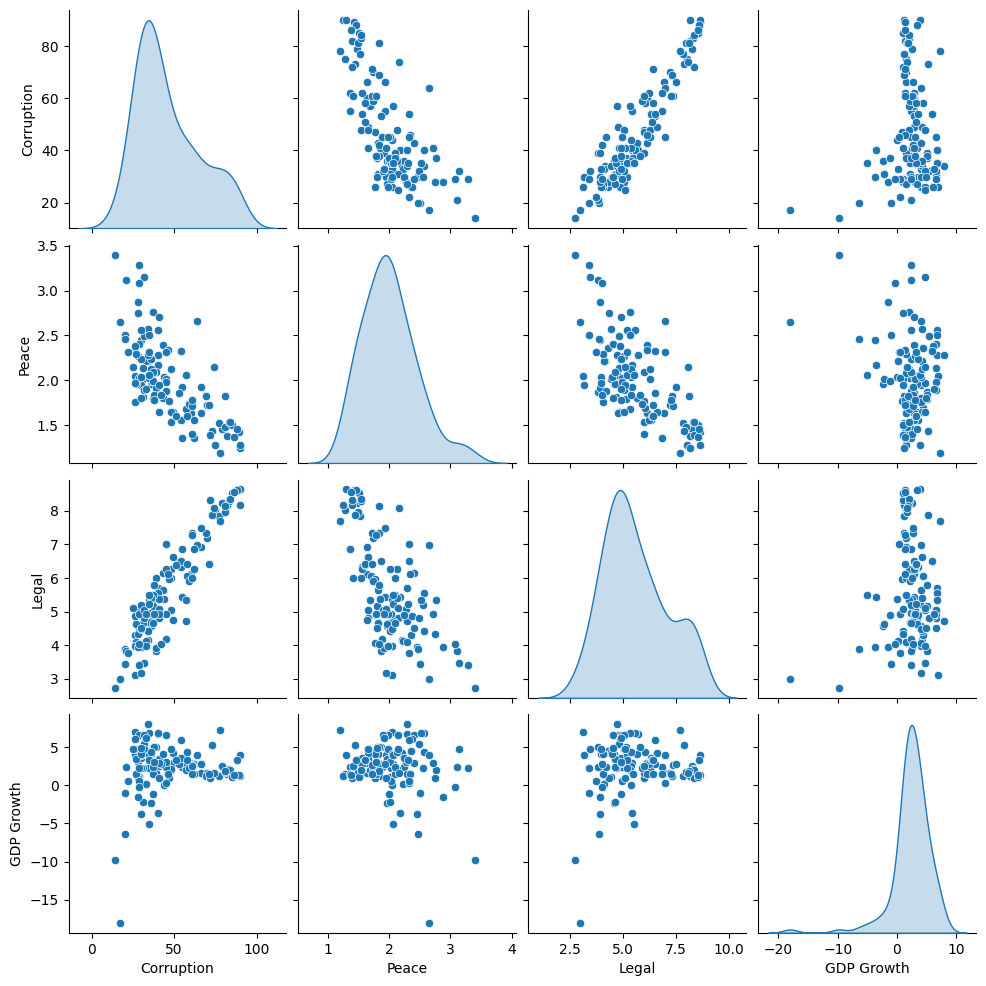

In [4]:
sns.pairplot(raw,vars=raw.columns[2:], diag_kind="kde")

## K means cluster
### Pick features & normalization

Let's normalize all the features, effectively making them equally important.

Ref. [Feature normalization.](https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering)

#### We could use StandardScaler from sklearn to do the normalization, but note that StandardScaler uses std with ddof=0 in the denominator, and there is no option for using ddof=1.  As a result, we opt for the more direct approach to do the normalization.

In [5]:
from sklearn.preprocessing import StandardScaler
X = raw[['Corruption','Peace', 'Legal', 'GDP Growth']]
X = pd.DataFrame(StandardScaler().fit_transform(X),columns = X.columns)
X.head(5)

,Corruption,Peace,Legal,GDP Growth
0,-0.379975,-0.306578,-1.199593,0.808020
1,-0.642472,0.469231,-0.971402,0.561381
2,-0.537473,-0.104778,-0.695954,-1.447586
3,-0.694971,0.480442,-0.994356,-0.673052
4,1.720000,-1.207951,1.785784,0.026378


In [6]:
X = raw[['Corruption','Peace', 'Legal', 'GDP Growth']]
X = (X - X.mean()) / X.std()
X.head(5)

,Corruption,Peace,Legal,GDP Growth
0,-0.378414,-0.305319,-1.194666,0.804702
1,-0.639833,0.467304,-0.967413,0.559075
2,-0.535266,-0.104348,-0.693096,-1.441641
3,-0.692117,0.478469,-0.990273,-0.670288
4,1.712936,-1.202990,1.778450,0.026269


### Perform elbow method

Ref. [Determining the number of clusters in a dataset.](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)

The marginal gain of adding one cluster drops quite a bit from $k=3$ to $k=4$. We will choose $k=3$ (not a clear cut though).

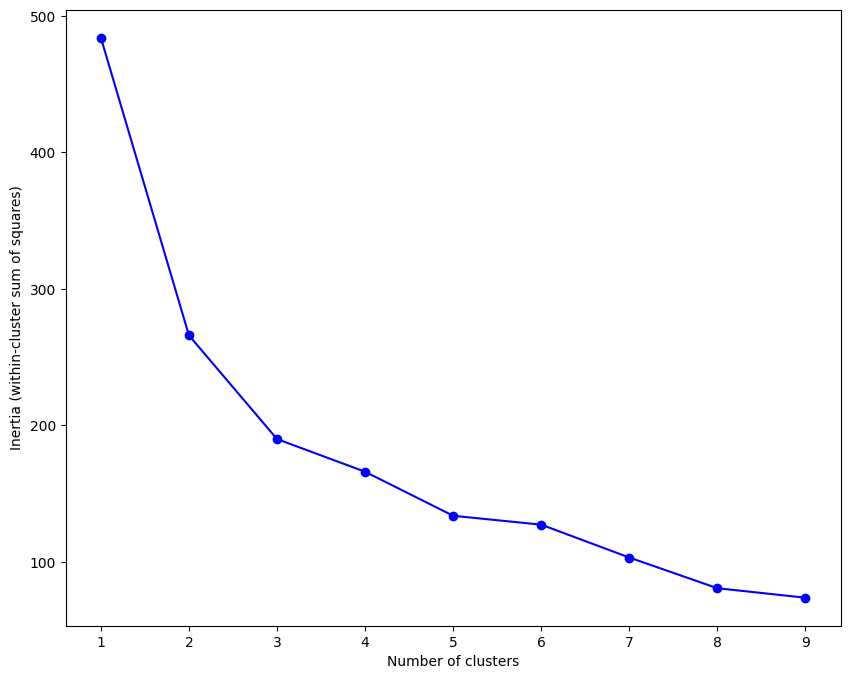

In [7]:
# https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

Ks = range(1, 10)
inertia = [KMeans(n_clusters=i,random_state=0).fit(X).inertia_ for i in Ks]
plt.figure(figsize=(10,8))
plt.plot(Ks, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.show()

### Silhouette Score

An alternative is to use average silhouette score to determine the optimal number of clusters.  Silhouette score is between -1 and 1.  Higher average silhouette score is better.  Based on the average silhouette score, it suggests the optimal number of clusters is 2.

Ref. [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))

In [8]:
for i in range(2,10):
    score = silhouette_score(X,KMeans(n_clusters=i,random_state=0).fit(X).labels_)
    print("For n_clusters = {}, silhouette score is {}".format(i, round(score,4)))

For n_clusters = 2, silhouette score is 0.424
For n_clusters = 3, silhouette score is 0.3984
For n_clusters = 4, silhouette score is 0.2831
For n_clusters = 5, silhouette score is 0.286
For n_clusters = 6, silhouette score is 0.2795
For n_clusters = 7, silhouette score is 0.293
For n_clusters = 8, silhouette score is 0.3077
For n_clusters = 9, silhouette score is 0.2932


### We will use 3 clusters in K-means clustering.

In [9]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X)

# print inertia & cluster center
print("Inertia for k=3 is", np.round(kmeans.inertia_,3))

Cluster_Table=pd.DataFrame(data=kmeans.cluster_centers_, columns=['Corruption','Peace', 'Legal', 'GDP Growth'])
Cluster_Table['Cluster'] = Cluster_Table.index
print("\nCluster centers:\n")
print(Cluster_Table.to_string(index=False))
# Add cluster labels to the dataframe
raw['Cluster Labels (KMeans)'] = kmeans.labels_
# take a quick look at the result for each country
pd.set_option("display.max_rows", None) # Show the enitre table 
raw

Inertia for k=3 is 190.045

Cluster centers:

 Corruption     Peace     Legal  GDP Growth  Cluster
  -0.474268  0.263118 -0.424249    0.412417        0
   1.226295 -0.975165  1.161167    0.006175        1
  -0.971989  1.215626 -1.016771   -1.615314        2


,Country,Abbrev,Corruption,Peace,Legal,GDP Growth,Cluster Labels (KMeans)
0,Albania,AL,39,1.867,3.822,5.000,0
1,Algeria,DZ,34,2.213,4.160,4.202,0
2,Argentina,AR,36,1.957,4.568,-2.298,2
3,Armenia,AM,33,2.218,4.126,0.208,2
4,Australia,AU,79,1.465,8.244,2.471,1
5,Austria,AT,75,1.278,8.012,1.482,1
6,Azerbaijan,AZ,30,2.450,3.946,-3.772,2
7,Bahrain,BH,43,2.398,6.157,2.915,0
8,Bangladesh,BD,26,2.045,3.117,6.923,0
9,Belgium,BE,77,1.528,7.839,1.239,1


### Do some pairwise scatterplots using Seaborn

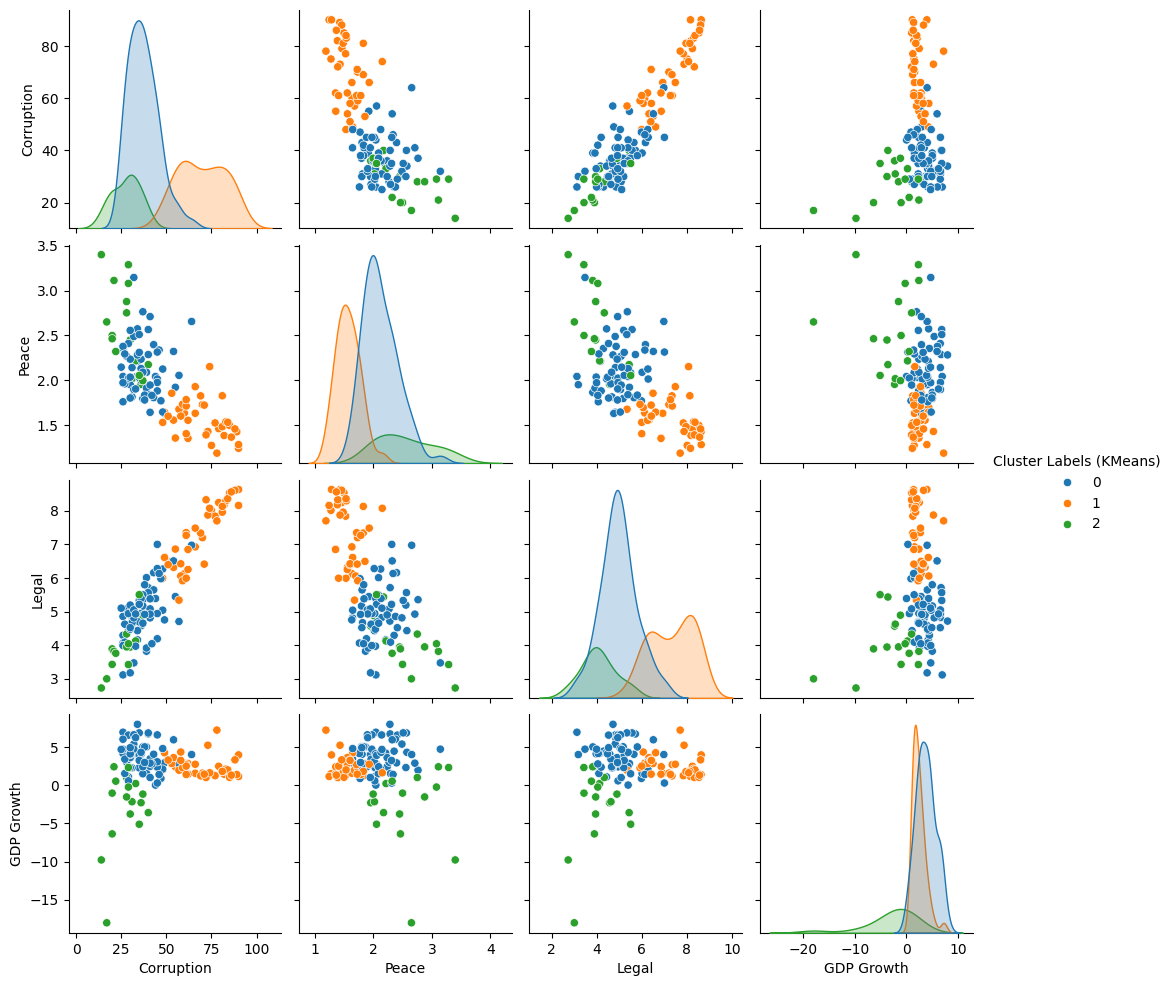

In [10]:
sns.pairplot(raw,vars=raw.columns[2:-1],hue='Cluster Labels (KMeans)',palette='tab10')

#### It appears that cluster 2 is the most risky set of countries because these countries have more corruption, less peaceful, little property right, and low GDP growth.  Countries in cluster 1 appears to be the least risky ones because they on average have less corruption, more peaceful, good property right, and low but stable GDP growth.  Cluster 0 contains countries that have medium country risk.

### Visualize the result (2D plots)

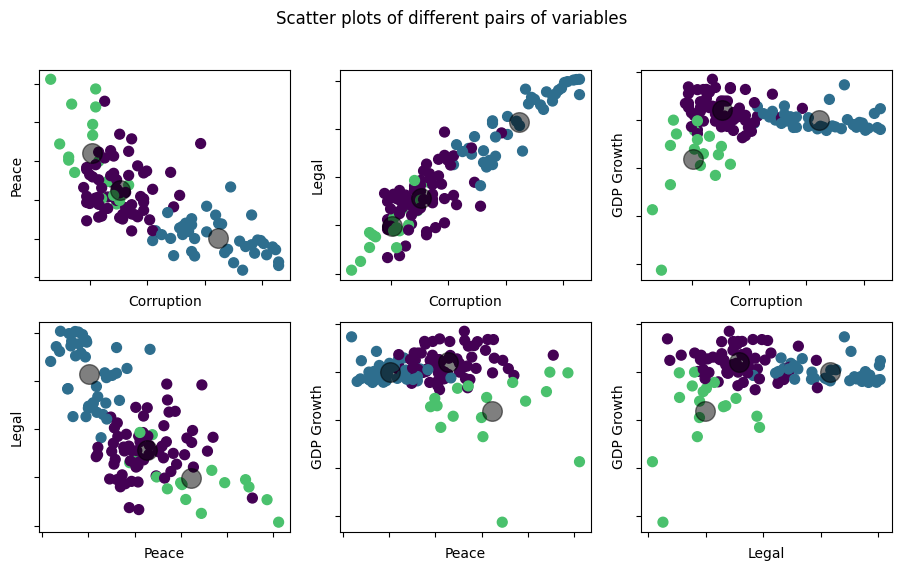

In [11]:
# Plot of the Scatter Figure among each pair 
fig, axs = plt.subplots(2, 3,figsize=(11,6))
fig.suptitle('Scatter plots of different pairs of variables')
Labels = ['Corruption','Peace','Legal','GDP Growth']
y = kmeans.labels_

# set up the color
norm = clrs.Normalize(vmin=0.,vmax=y.max()+0.8)
cmap = cm.viridis

# Plot the Figure
m=0
for i in range(len(Labels)-1):
    for j in range(1,len(Labels)-i):
        axs.flat[m].scatter(X[Labels[i]],X[Labels[i+j]],c=cmap(norm(y)), s=50)
        axs.flat[m].scatter(Cluster_Table[Labels[i]], Cluster_Table[Labels[i+j]], c='black', s=200, alpha=0.5)
        axs.flat[m].set_xlabel(Labels[i])
        axs.flat[m].set_ylabel(Labels[i+j])
        # Turn off tick labels.
        axs.flat[m].set_yticklabels([])
        axs.flat[m].set_xticklabels([])
        m=m+1

### Visualize the result (2D plots)
plot country abbreviations instead of dots.

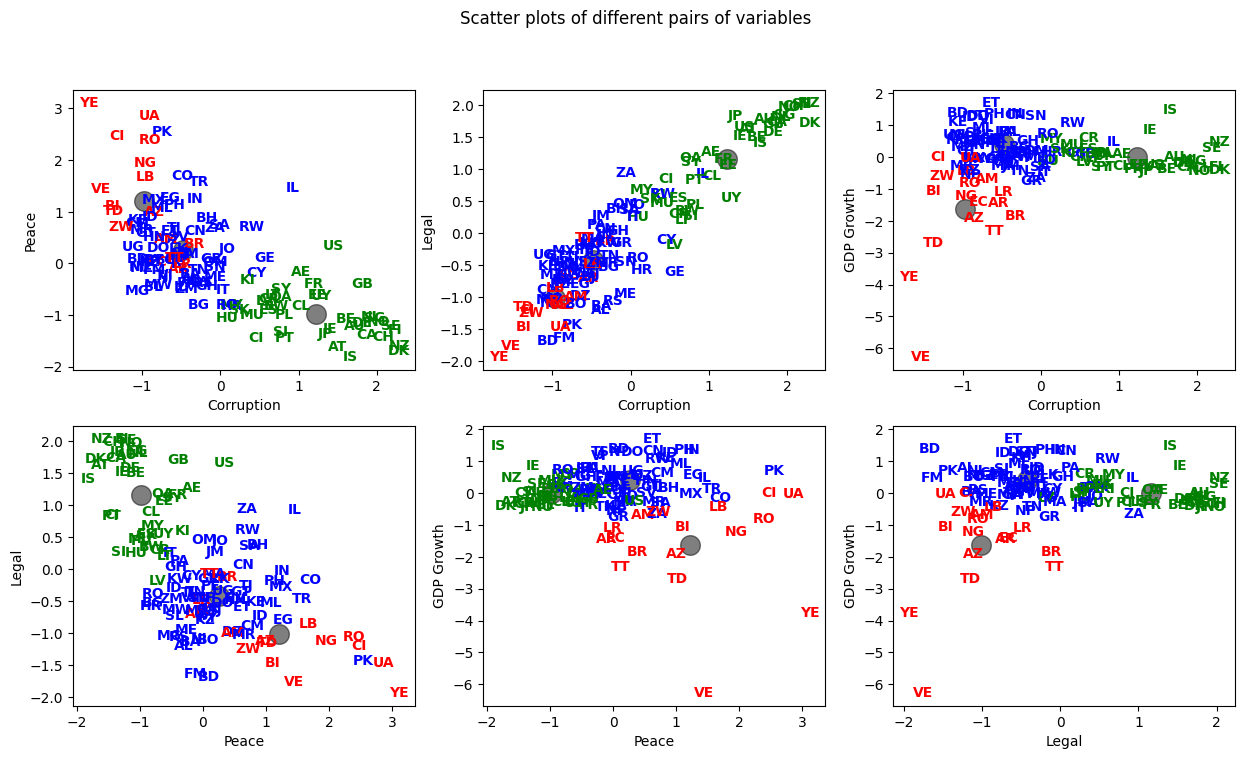

In [12]:
# Plot of the Scatter Figure among each pair 
fig, axs = plt.subplots(2, 3,figsize=(15,8)) 
fig.suptitle('Scatter plots of different pairs of variables')
Labels = ['Corruption','Peace','Legal','GDP Growth']
colors = ['blue','green', 'red']

# set up the color
norm = clrs.Normalize(vmin=0.,vmax=y.max() + 0.8)
cmap = cm.viridis

# Plot the Figure
m=0
for i in range(len(Labels)-1):
    for j in range(1,len(Labels)-i):
        axs.flat[m].scatter(X[Labels[i]],X[Labels[i+j]],c=y, s=0, alpha=0)
        axs.flat[m].scatter(Cluster_Table[Labels[i]], Cluster_Table[Labels[i+j]], c='black', s=200, alpha=0.5)
        axs.flat[m].set_xlabel(Labels[i])
        axs.flat[m].set_ylabel(Labels[i+j])       
        for h in range(X.shape[0]):
            axs.flat[m].text(X[Labels[i]].iloc[h], X[Labels[i+j]].iloc[h], raw['Abbrev'].iloc[h], 
                 color=colors[y[h]], weight='semibold', horizontalalignment = 'center', verticalalignment = 'center')       
        m=m+1

### List the result

In [13]:
result = pd.DataFrame({'Country':raw['Country'], 'Abbrev':raw['Abbrev'], 'Label':y})
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(result.sort_values('Label'))

                          Country Abbrev  Label
0                         Albania     AL      0
70                        Moldova     FM      0
69                         Mexico     MX      0
67                     Mauritania     MR      0
66                           Mali     ML      0
64                         Malawi     MW      0
63                     Madagascar     MG      0
111                        Uganda     UG      0
120                        Zambia     ZM      0
71                     Montenegro     ME      0
58                         Kuwait     KW      0
55                     Kazakhstan     KZ      0
54                         Jordan     JO      0
106                      Thailand     TJ      0
52                        Jamaica     JM      0
51                          Italy     IT      0
50                         Israel     IL      0
48                           Iran     ID      0
47                      Indonesia     ID      0
56                          Kenya     KE

### We now try agglomerative clustering with Ward's criterion

In [14]:
k = 3
agg = AgglomerativeClustering(n_clusters=k,linkage='ward')
agg.fit(X)

AgglomerativeClustering(n_clusters=3)

#### Compute the cluster centers

In [15]:
X1 = X.copy()
X1['Cluster'] = agg.labels_
center = X1.groupby('Cluster').mean()
print(center)

         Corruption     Peace     Legal  GDP Growth
Cluster                                            
0          0.919801 -0.631339  0.918468   -0.014256
1         -0.903629  1.289763 -0.937157   -1.228068
2         -0.614248  0.108216 -0.597050    0.590917


#### Compute the inertia

### Two different ways of computing inertia

In [16]:
means = X1.groupby('Cluster').transform('mean')
inertia = ((X-means)**2).sum().sum()
print(inertia)

214.80328063346766


In [17]:
inertia = X1.groupby('Cluster').transform(lambda x: (x-x.mean())**2).sum().sum()
print(inertia)

214.80328063346766


#### Note that the three clusters under the Ward's method are different from those obtained under K-means.  Although both Ward's method and K-means clustering use sum-of-squares as criterion for clustering, Ward’s method is both greedy, and constrained by previous choices as to which clusters to form. This means its sum-of-squares for a given number of clusters ($k$) is usually larger than the minimum for that $k$, and in general larger than what K-means will achieve.  For our problem, the inertia for K-means clustering is 189.7 but it is 206.3 for Ward's method.

In [18]:
# Add agglomerative cluster labels to the dataframe
raw['Cluster Labels (Agglo.)'] = agg.labels_
# take a quick look at the result for each country
pd.set_option("display.max_rows", None) # Show the enitre table 
raw

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth,Cluster Labels (KMeans),Cluster Labels (Agglo.)
0,Albania,AL,39,1.867,3.822,5.000,0,2
1,Algeria,DZ,34,2.213,4.160,4.202,0,2
2,Argentina,AR,36,1.957,4.568,-2.298,2,1
3,Armenia,AM,33,2.218,4.126,0.208,2,1
4,Australia,AU,79,1.465,8.244,2.471,1,0
5,Austria,AT,75,1.278,8.012,1.482,1,0
6,Azerbaijan,AZ,30,2.450,3.946,-3.772,2,1
7,Bahrain,BH,43,2.398,6.157,2.915,0,0
8,Bangladesh,BD,26,2.045,3.117,6.923,0,2
9,Belgium,BE,77,1.528,7.839,1.239,1,0
